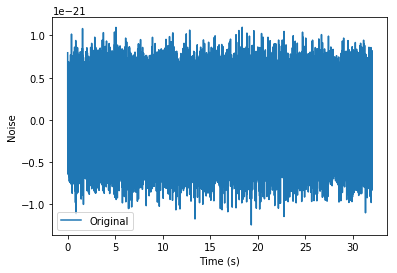

In [6]:
# https://pycbc.org/pycbc/latest/html/pycbc.noise.html
# http://pycbc.org/pycbc/latest/html/noise.html

import pycbc.noise
import pycbc.psd
import pylab
from pycbc.filter import resample_to_delta_t, highpass

# ?????? which psd simulatiom to use? ????how to determine which parameter?
# pycbc.psd.analytical.aLIGOZeroDetHighPower(length, delta_f, low_freq_cutoff)

flow = 15.0 # low frequency cutoff
delta_f = 1.0 / 32
flen = int(2048 / delta_f) + 1  #?????????? since psd is a frequency series, this probably desides the high freq cutoff
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 1 seconds of noise at 4096 Hz
# ??????why inside the flen, total frequency twice of that here, which means noise datapoint density double that of psd?
delta_t = 1.0 / 4096
tsamples = int(32 / delta_t)# number of datapoints needed for 32 seconds
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

pylab.plot(ts.sample_times, ts,label='Original')

# Suppress the low frequencies below 30 Hz
#ts = pycbc.filter.highpass(ts, 30.0)
#pylab.plot(ts.sample_times, ts, label='Highpassed')

# Suppress the high frequencies
#ts = pycbc.filter.lowpass_fir(ts, 1000.0, 8)
#pylab.plot(ts.sample_times, ts, label='Highpassed + Lowpassed')

pylab.legend()
pylab.ylabel('Noise')
pylab.xlabel('Time (s)')
pylab.show()

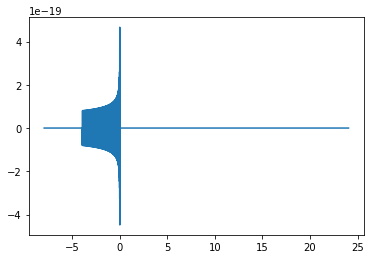

In [7]:
from pycbc.waveform import get_td_waveform

m = 20 # Solar masses
#????? use hp or hc, which one? does it matter?
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=ts.delta_t,
                     f_lower=15.0)

#resize to noise length
hp.resize(len(ts))

shifted = hp.cyclic_time_shift(4)

pylab.plot(shifted.sample_times,shifted)
pylab.show()


27503.19657244667


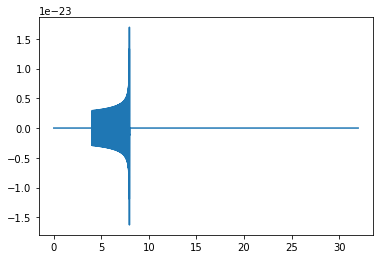

In [8]:
# normalize template to SNR 1
# scale the template so that it would have SNR 1 in this data
from pycbc.filter import sigma 
print(sigma(shifted, psd=psd, low_frequency_cutoff=20.0))
shifted /= sigma(shifted, psd=psd, low_frequency_cutoff=20.0)

shifted.start_time = ts.start_time

pylab.plot(shifted.sample_times,shifted)
pylab.show()

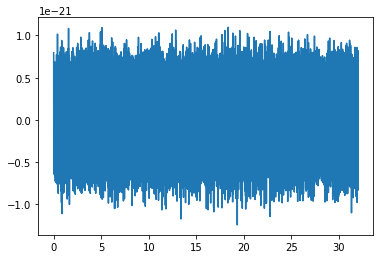

In [4]:
# try embed
embed = ts + shifted

pylab.plot(embed.sample_times, embed)
pylab.show()


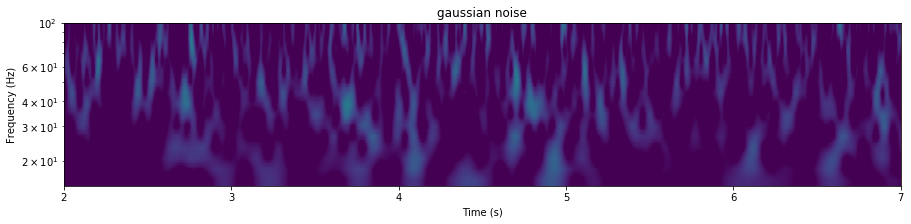

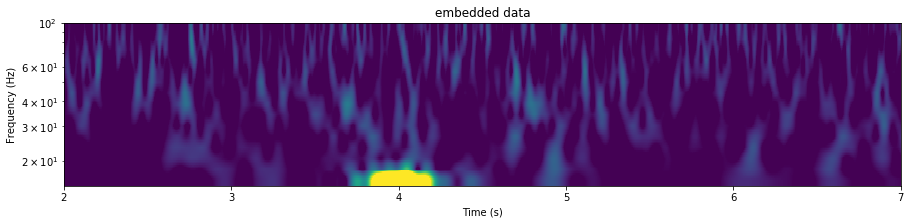

In [5]:
# Visualize

#several issues: doesn't look like data signal in the matched filtering method
# seems to be low freq
# why no data from 0-2..?

for data, title in [(ts, 'gaussian noise'),
                    (embed, 'embedded data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(15, 100))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(2, 7)
    pylab.show()

In [135]:
# whitening
# white noise is a random signal having equal intensity at different frequencies, giving it a constant power spectral density.
# what is whitening for

In [ ]:
# this shows if I change length of psd, must change other stuff too. 

from pycbc.filter.resample import interpolate_complex_frequency

print(psd.delta_t,psd.delta_f,ts.delta_f,shifted.delta_t,shifted.delta_f)

interpolate_complex_frequency(psd, shifted.delta_f, zeros_offset=0, side='right')

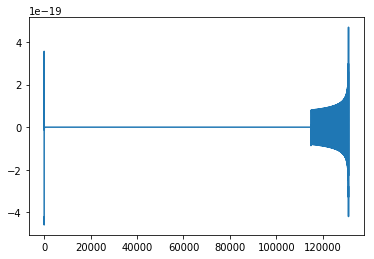

In [248]:
#Try detect signal with matched filter

from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samles of our time series in Welch method.
psd = ts.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, ts.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * ts.sample_rate,
                                  low_frequency_cutoff=15)

#template
template = hp.cyclic_time_shift(hp.start_time)

pylab.plot(template)
pylab.show()

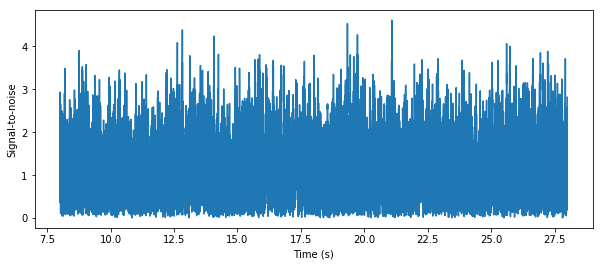

We found a signal at 21.0830078125s with SNR 4.609877348697315


In [249]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, embed,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))